In [2]:
from pmdarima import auto_arima
import pmdarima as pm
from pandas.plotting import autocorrelation_plot

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [4]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib import pyplot
from pandas import DataFrame
from numpy import log

In [6]:
df_american = pd.read_excel(r'/Users/dilianaserafimova/Desktop/American_Airlines.xlsx')

In [7]:
df_american.head()

,Year,Month,date,flight_domestic,flight_int,pax_count,revenue,seat_miles,load_factor,flights
0,2002,10,2002 10,"6,483,209","1,268,032","7,751,241","9,981,313","14,558,503",68.56,"83,649"
1,2002,11,2002 11,"5,836,804","1,248,937","7,085,741","9,102,300","13,472,175",67.56,"77,398"
2,2002,12,2002 12,"6,473,000","1,428,359","7,901,359","10,351,711","14,119,643",73.31,"79,962"
3,2002,TOTAL,2002 TOTAL,"77,435,542","16,564,424","93,999,966","121,504,345","171,711,646",70.76,"990,931"
4,2003,1,2003 1,"5,659,172","1,354,646","7,013,818","9,405,547","14,038,698",67.00,"78,214"


## Delete irrelevant data / years / months 

#### Delete irrelevant date

In [8]:
indexNames = df_american[df_american['Year'] == 2002].index
df_american.drop(indexNames , inplace=True)


In [9]:
indexNames = df_american[df_american['Year'] == 2020].index
df_american.drop(indexNames , inplace=True)

In [10]:
indexNames = df_american[df_american['Year'] == 2021].index
df_american.drop(indexNames , inplace=True)

In [11]:
indexNames = df_american[df_american['Year'] == 2022].index
df_american.drop(indexNames , inplace=True)

#### Delete irrelevant content

In [12]:
indexNames = df_american[df_american['Month'] == 'TOTAL'].index
df_american.drop(indexNames , inplace=True)

#### Delete irrelevant column

In [13]:
df_american = df_american.drop(["flight_domestic", "flight_int", 'Year', 'Month'], axis=1)

#### Delete NaN

In [14]:
incomplete_columns = list(df_american.columns[df_american.isnull().any()])

In [15]:
incomplete_columns

[]

#### Datensatz ist vollständig

## Convert argument to datetime

In [16]:
df_american['date'] = pd.to_datetime(df_american['date'])

In [17]:
df_american.head()

,date,pax_count,revenue,seat_miles,load_factor,flights
4,2003-01-01,"7,013,818","9,405,547","14,038,698",67.00,"78,214"
5,2003-02-01,"6,363,926","8,355,084","12,142,241",68.81,"67,463"
6,2003-03-01,"7,628,481","9,981,627","13,929,984",71.66,"77,125"
7,2003-04-01,"7,103,085","9,325,622","13,210,596",70.59,"73,182"
8,2003-05-01,"7,447,462","9,838,460","13,345,197",73.72,"73,381"


## Convert data types

In [18]:
df_american.dtypes

date           datetime64[ns]
pax_count              object
revenue                object
seat_miles             object
load_factor           float64
flights                object
dtype: object

In [19]:
df_american['pax_count'] = df_american['pax_count'].str.replace('[^\w\s]','').astype(int)

/var/folders/_h/_0hrsyw93ljbt2ws9kq8w6z40000gn/T/ipykernel_2826/1319109083.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_american['pax_count'] = df_american['pax_count'].str.replace('[^\w\s]','').astype(int)


In [20]:
df_american['revenue'] = df_american['revenue'].str.replace('[^\w\s]','').astype(int)

/var/folders/_h/_0hrsyw93ljbt2ws9kq8w6z40000gn/T/ipykernel_2826/2518242079.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_american['revenue'] = df_american['revenue'].str.replace('[^\w\s]','').astype(int)


In [21]:
df_american['seat_miles'] = df_american['seat_miles'].str.replace('[^\w\s]','').astype(int)

/var/folders/_h/_0hrsyw93ljbt2ws9kq8w6z40000gn/T/ipykernel_2826/2597891616.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_american['seat_miles'] = df_american['seat_miles'].str.replace('[^\w\s]','').astype(int)


In [22]:
df_american['flights'] = df_american['flights'].str.replace('[^\w\s]','').astype(int)

/var/folders/_h/_0hrsyw93ljbt2ws9kq8w6z40000gn/T/ipykernel_2826/4142843975.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_american['flights'] = df_american['flights'].str.replace('[^\w\s]','').astype(int)


In [23]:
df_american.head()

,date,pax_count,revenue,seat_miles,load_factor,flights
4,2003-01-01,7013818,9405547,14038698,67.00,78214
5,2003-02-01,6363926,8355084,12142241,68.81,67463
6,2003-03-01,7628481,9981627,13929984,71.66,77125
7,2003-04-01,7103085,9325622,13210596,70.59,73182
8,2003-05-01,7447462,9838460,13345197,73.72,73381


# Support Machine Vector

In [44]:
paxes = df_american['pax_count']
size = int(len(paxes) * 0.8)
training_set, test_set = df_american[0:size], df_american[size:len(paxes)]
test_set.head(3)

,date,pax_count,revenue,seat_miles,load_factor,flights
180,2016-08-01,12704813,18239760,21833789,83.54,96048
181,2016-09-01,11220742,15765724,19169639,82.24,86065
182,2016-10-01,11764077,16332729,19622032,83.24,88625


In [45]:
from sklearn.svm import SVR


In [46]:
dates = training_set['date'].to_numpy()
paxes = training_set['pax_count'].to_numpy()

In [47]:
dates = np.reshape(dates, (len(dates), 1))
paxes = np.reshape(paxes, (len(paxes), 1))

In [48]:
svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, paxes.ravel())

SVR(C=1000.0, gamma=0.1)

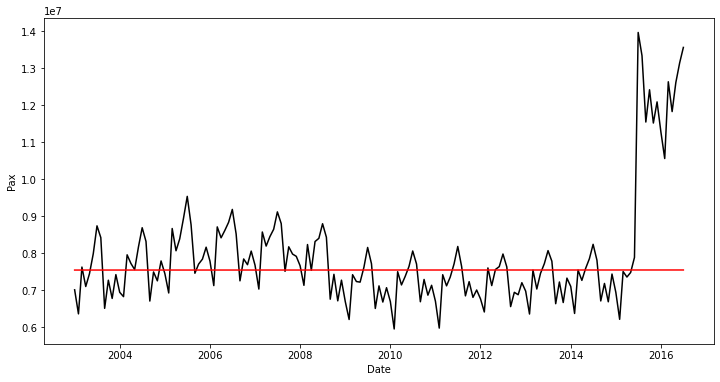

In [49]:
plt.figure(figsize = (12,6))
plt.plot(dates, paxes, color= 'black', label= 'Data')
plt.plot(training_set['date'], svr_rbf.predict(dates), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Pax')
plt.show()